## Data preparation for network anomaly detection dataset

In [2]:
import numpy as np # numpy is THE toolbox for scientific computing with python
import pandas as pd # pandas provides THE data structure and data analysis tools for data scientists 

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# seaborn plotting 
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set_theme(style="darkgrid")

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [14]:
data = pd.read_csv("Train-datas.csv")

columns_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

data = np.array(data)

df = pd.DataFrame(data,columns=columns_names)

As we can see 'land', 'urgent', 'numfailedlogins', 'numoutboundcmds' have mostly zero values so we can drop these columns.

In [7]:
df.drop(['land','urgent','num_failed_logins','num_outbound_cmds',"src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","last_flag"],axis=1,inplace=True)

In [15]:
df['attack'].loc[df['attack']!='normal']='attack'

In [16]:
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.0,0.6,0.88,0.0,0.0,0.0,0.0,0.0,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.1,0.05,0.0,0.0,1.0,1.0,0.0,0.0,attack,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.0,0.0,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.0,0.0,0.0,0.0,1.0,1.0,attack,21


In [17]:
le=LabelEncoder()

df['protocol_type']=le.fit_transform(df['protocol_type'])
df['service']=le.fit_transform(df['service'])
df['flag']=le.fit_transform(df['flag'])
df['attack']=le.fit_transform(df['attack'])

In [1]:
from pycaret.classification import *

In [18]:
s= setup(df, target = 'attack', session_id = 42, data_split_stratify=True)

,Description,Value
0,Session id,42
1,Target,attack
2,Target type,Binary
3,Original data shape,"(125972, 43)"
4,Transformed data shape,"(125972, 85)"
5,Transformed train set shape,"(88180, 85)"
6,Transformed test set shape,"(37792, 85)"
7,Numeric features,3
8,Categorical features,39
9,Preprocess,True


In [19]:
best_model = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9992,1.0000,0.9994,0.9991,0.9993,0.9984,0.9984,2.6840
et,Extra Trees Classifier,0.9990,1.0000,0.9990,0.9992,0.9991,0.9981,0.9981,2.7530
lightgbm,Light Gradient Boosting Machine,0.9994,1.0000,0.9995,0.9994,0.9995,0.9988,0.9988,1.3700
gbc,Gradient Boosting Classifier,0.9953,0.9998,0.9944,0.9969,0.9956,0.9906,0.9906,5.6090
ada,Ada Boost Classifier,0.9911,0.9995,0.9921,0.9912,0.9916,0.9820,0.9820,2.6700
knn,K Neighbors Classifier,0.9952,0.9983,0.9947,0.9963,0.9955,0.9903,0.9903,3.6520
dt,Decision Tree Classifier,0.9979,0.9979,0.9979,0.9981,0.9980,0.9958,0.9958,0.9820
qda,Quadratic Discriminant Analysis,0.9461,0.9955,0.8998,0.9993,0.9453,0.8929,0.8997,1.2770
ridge,Ridge Classifier,0.9749,0.9947,0.9720,0.9809,0.9764,0.9496,0.9497,0.8170
lda,Linear Discriminant Analysis,0.9749,0.9947,0.9720,0.9809,0.9764,0.9496,0.9497,1.2300


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

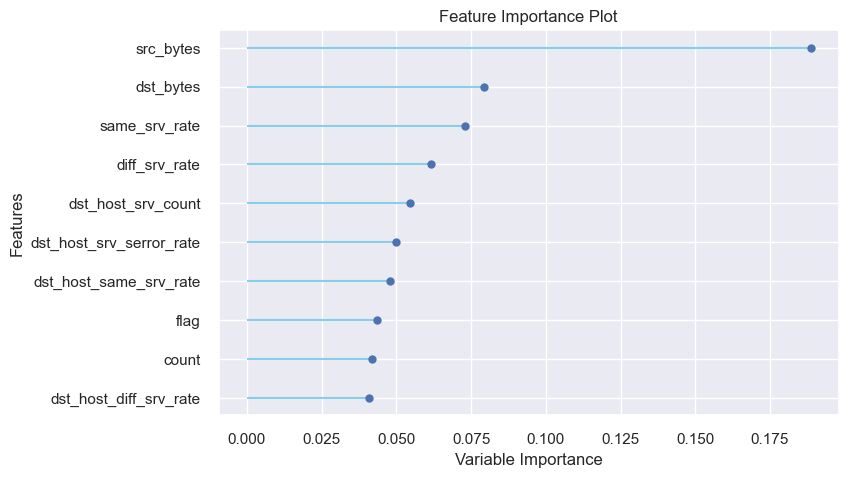

In [20]:
# plot feature importance
plot_model(best_model, plot = 'feature')

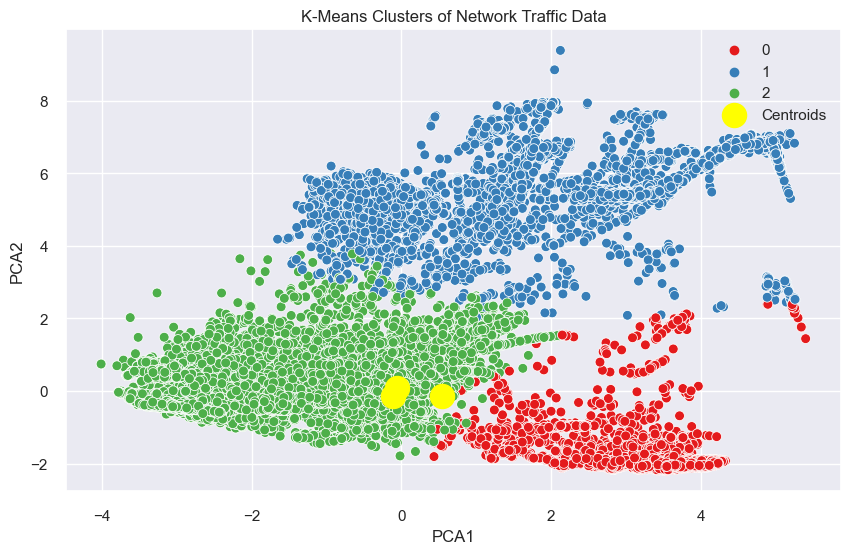

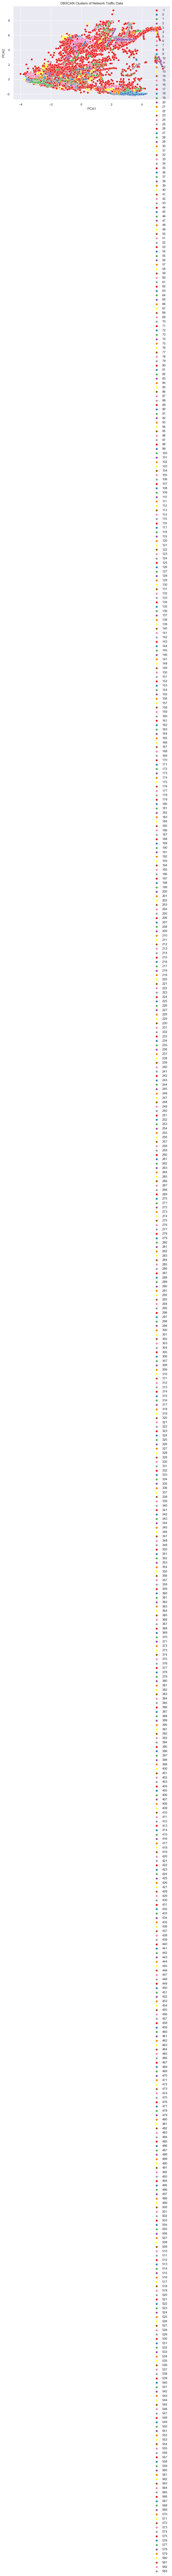

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# Clustering der Daten
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.drop('attack', axis=1))

# K-Means Clustering
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster_KMeans'] = kmeans.fit_predict(scaled_df)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(scaled_df)

# Visualisierung der Cluster mit PCA (K-Means)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_KMeans', palette='Set1', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
plt.title('K-Means Clusters of Network Traffic Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


# Visualisierung der Cluster mit PCA (DBSCAN)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_DBSCAN', palette='Set1', s=50)
plt.title('DBSCAN Clusters of Network Traffic Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()